# Read data and preprocessing

In [28]:
import pandas as pd

df = pd.read_csv('./matches.csv',index_col=0)

print(df.head())
print(df.shape)

df['date'] = pd.to_datetime(df['date'])
print(df.dtypes)


         date   time            comp        round  day venue result   gf   ga  \
1  2023-08-12  12:30  Premier League  Matchweek 1  Sat  Home      W  2.0  1.0   
2  2023-08-21  20:00  Premier League  Matchweek 2  Mon  Away      W  1.0  0.0   
3  2023-08-26  15:00  Premier League  Matchweek 3  Sat  Home      D  2.0  2.0   
4  2023-09-03  16:30  Premier League  Matchweek 4  Sun  Home      W  3.0  1.0   
5  2023-09-17  16:30  Premier League  Matchweek 5  Sun  Away      W  1.0  0.0   

            opponent  ...  match report  notes    sh  sot  dist   fk pk pkatt  \
1  Nottingham Forest  ...  Match Report    NaN  15.0  7.0  19.1  0.0  0     0   
2     Crystal Palace  ...  Match Report    NaN  13.0  2.0  16.4  0.0  1     1   
3             Fulham  ...  Match Report    NaN  18.0  9.0  13.8  0.0  1     1   
4  Manchester United  ...  Match Report    NaN  17.0  5.0  15.0  0.0  0     0   
5            Everton  ...  Match Report    NaN  13.0  4.0  17.4  0.0  0     0   

   season     team  
1    

In [29]:
# Convert venue,team and opponent to codes
df['venue_code'] = df['venue'].astype('category').cat.codes
df['team_code'] = df['team'].astype('category').cat.codes
df['opp_code'] = df['opponent'].astype('category').cat.codes

# Convert time to hour remove min
df['hour'] = df['time'].str.replace(':.+','',regex=True).astype('int')

# Convert date to day of week code (0-6)
df['day_code'] = df['date'].dt.dayofweek

result_mapping = {'W':1,'D':0,'L':-1}
df['target'] = df['result'].map(result_mapping)

# Apply model

In [30]:
from sklearn.model_selection import train_test_split

X = df[['venue_code','team_code','opp_code','hour','day_code']]
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0)

In [31]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, min_samples_split=5, random_state=0)

In [32]:
model.fit(X_train,y_train)

RandomForestClassifier(min_samples_split=5, random_state=0)

In [33]:
preds = model.predict(X_test)

# Evaluate

In [34]:
from sklearn.metrics import confusion_matrix

combined = pd.DataFrame(dict(actual=y_test,prediction=preds))
crs = pd.crosstab(index=combined['actual'],columns=combined['prediction'])
crs

prediction,-1,0,1
actual,,,
-1,15,1,13
0,12,5,11
1,13,4,30


In [35]:
15/29

0.5172413793103449

Win accuracy:  0.6382978723404256
Draw accuracy:  0.17857142857142858
Loss accuracy:  0.5172413793103449
Overall accuracy:  0.4807692307692308


<Axes: title={'center': 'Loss'}, ylabel='-1'>

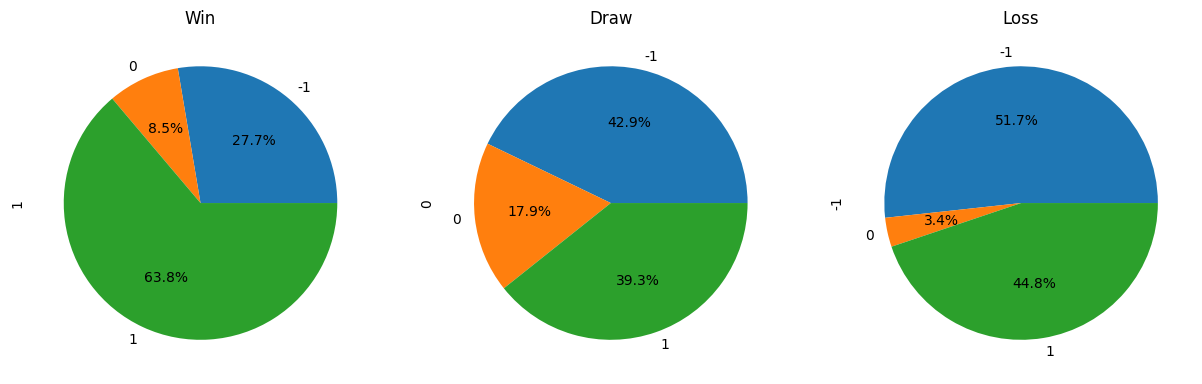

In [36]:
print("Win accuracy: ",crs.loc[1,1]/crs.loc[1].sum())
print("Draw accuracy: ",crs.loc[0,0]/crs.loc[0].sum())
print("Loss accuracy: ",crs.loc[-1,-1]/crs.loc[-1].sum())
print("Overall accuracy: ",model.score(X_test,y_test))


# Show pie charts 
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,3,figsize=(15,5))

crs.loc[1].plot.pie(autopct='%1.1f%%',ax=ax[0],title='Win')
crs.loc[0].plot.pie(autopct='%1.1f%%',ax=ax[1],title='Draw')
crs.loc[-1].plot.pie(autopct='%1.1f%%',ax=ax[2],title='Loss')


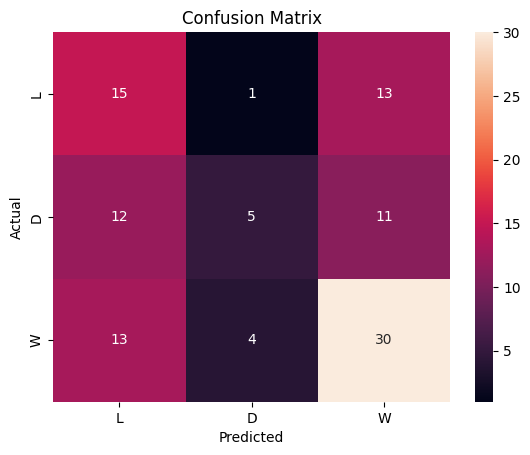

In [37]:
# Show heatmap
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test,preds)
sns.heatmap(cm,annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.xticks([0.5,1.5,2.5],['L','D','W'])
plt.yticks([0.5,1.5,2.5],['L','D','W'])

plt.show()


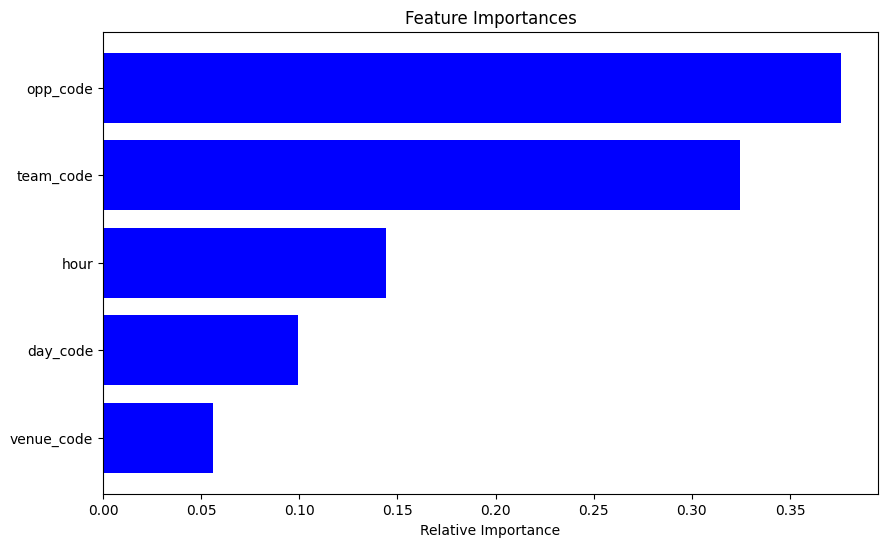

In [38]:
import matplotlib.pyplot as plt
# Show feature importance
importances = model.feature_importances_
features = X.columns
indices = importances.argsort()

plt.figure(figsize=(10,6))
plt.title('Feature Importances')
plt.barh(range(len(indices)),importances[indices],color='b',align='center')
plt.yticks(range(len(indices)),[features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Apply to predict the next game 

In [39]:
model.fit(X,y)

RandomForestClassifier(min_samples_split=5, random_state=0)

In [40]:
MCI_vs_WHU = [1,12,18,16,6]
ARS_vs_EVE = [1,0,8,16,6]

m1 =model.predict([MCI_vs_WHU])
m2 =model.predict([ARS_vs_EVE])

if m1 == 1 : print("Manchester City will win")
elif m1 == 0: print("Manchester City will draw")
else: print("Manchester City will lose")

if m2 == 1 : print("Arsenal will win")
elif m2 == 0: print("Arsenal will draw")
else: print("Arsenal will lose")

print('__END__')

Manchester City will draw
Arsenal will win
__END__


c:\Users\ADMIN\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\ADMIN\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
